# Project for modeling the temperature of steel in a ladle in order to optimize energy consumption.

### Task

To optimize production costs, the steel mill decided to reduce energy consumption during the steel processing phase. It is necessary to build a model that will predict the temperature of steel.

### Description of the technological process

The steel is processed in a metal ladle with a capacity of about 100 tons. To ensure that the ladle can withstand high temperatures, the inside is lined with refractory bricks. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the bucket lid.

Sulfur is removed from the alloy (desulfurization), the chemical composition is adjusted by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of the alloy from a bunker for bulk materials or wire through a special tribe apparatus (English tribe, “mass”).

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is performed. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is mixed and measurements are taken again. This cycle is repeated until the target chemical composition and optimal melting temperature are achieved.

Then the molten steel is sent for finishing of the metal or enters a continuous casting machine. From there the finished product comes out in the form of slabs (English *slab*, “slab”).

### Data description:
The data consists of files obtained from different sources:
* data_arc.csv — data about electrodes;
* data_bulk.csv — data on the supply of bulk materials (volume);
* data_bulk_time.csv — data on the supply of bulk materials (time);
* data_gas.csv — data on purging the alloy with gas;
* data_temp.csv — temperature measurement results;
* data_wire.csv — data on wire materials (volume);
* data_wire_time.csv - data about wire materials (time).

In all files, the key column contains the batch number. There may be several lines in the files with the same key value: they correspond to different iterations of processing.

The modeling object is one ladle (one cooking process), which is determined by a unique key.

### Conditions:

* Target feature: last temperature for a unique batch;
*Target Metric: MAE;
* Success criterion: obtaining MAE metric < 6.8;
* Only the first temperature examined before the process can be used as a sign;
* In case of incorrect data (one measurement; a value contrary to common sense), the data is considered unsuitable for the entire batch to which this data relates.

### Work plan:

* Data loading;
* Exploratory data analysis;
* Data preprocessing;
* Development and selection of the best model with subsequent testing on a test sample;
* Report.

## 1. Loading data

In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.4 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#to be used in random_state throughout the work
SEED = 220523

In [21]:
path_list = ['/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_arc_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_bulk_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_bulk_time_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_gas_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_temp_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_wire_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_wire_time_new.csv']

df_dict = {}

for i, path in enumerate(path_list):
    try:
        df_name = path.\
                  replace('/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_', '').\
                  replace('_new.csv', '')
        df_dict[df_name] = pd.read_csv(path)
        print(f'DataFrame {df_name} downloaded successfully!')
    except:
        print(f'An error occurred while downloading the DataFrame {df_name}')

DataFrame arc downloaded successfully!
DataFrame bulk downloaded successfully!
DataFrame bulk_time downloaded successfully!
DataFrame gas downloaded successfully!
DataFrame temp downloaded successfully!
DataFrame wire downloaded successfully!
DataFrame wire_time downloaded successfully!


**Rename the columns' names to English translation**

In [24]:
df_dict['arc'] = df_dict['arc'].rename(columns={'Начало нагрева дугой': 'Start of arc heating',
                                                'Конец нагрева дугой': 'End of arc heating',
                                                'Активная мощность': 'Active power',
                                                'Реактивная мощность': 'Reactive power'})

df_dict['gas'] = df_dict['gas'].rename(columns={'Газ 1': 'Gas 1'})

df_dict['temp'] = df_dict['temp'].rename(columns={'Время замера': 'Measurement time',
                                                'Температура': 'Temperature'})

In [25]:
for key, df in df_dict.items():
    print(f"Shape of DataFrame '{key}' is {df.shape} \n")

Shape of DataFrame 'arc' is (14876, 5) 

Shape of DataFrame 'bulk' is (3129, 16) 

Shape of DataFrame 'bulk_time' is (3129, 16) 

Shape of DataFrame 'gas' is (3239, 2) 

Shape of DataFrame 'temp' is (18092, 3) 

Shape of DataFrame 'wire' is (3081, 10) 

Shape of DataFrame 'wire_time' is (3081, 10) 



## 2. Exploratory data analysis

**To conduct a primary research analysis of data from each of the available dataframes, we will display information on each of them.**

### 2.1 Electrode data

In [27]:
# function that will display the number of gaps in fractions and other information
def info_func(dataframe, name):
     key = name
     df = dataframe.copy()
     null_shares = df.isnull().sum() / len(df)
     total_objects = len(df)
     column_types = df.dtypes
     info_df = pd.DataFrame({'Null%': null_shares, \
                             'Total': total_objects, \
                             'Total_Null': df.isnull().sum(), \
                             'Type': column_types})
     print(f'Number of gaps in shares in the dataframe "{key}" \n\n{info_df}\n\n')
     print(f'First 5 lines in dataframe "{key}" \n \n {df.head()} \n\n')
     print(f'Description of the distribution in the dataframe "{key}" \n\n{df.describe()}\n\n')
     print(f'Number of complete duplicates in dataframe "{key}" = {df.duplicated().sum()}')
     return

info_func(df_dict['arc'], 'arc')

Number of gaps in shares in the dataframe "arc" 

                      Null%  Total  Total_Null     Type
key                     0.0  14876           0    int64
Start of arc heating    0.0  14876           0   object
End of arc heating      0.0  14876           0   object
Active power            0.0  14876           0  float64
Reactive power          0.0  14876           0  float64


First 5 lines in dataframe "arc" 
 
    key Start of arc heating   End of arc heating  Active power  Reactive power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130        0.211253
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658        0.477438
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36      0.580313        0.430460
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19      0.518496        0.379979
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37      0.867133        0.643691 


Description of the distribution in the dataframe "arc" 

                key  Active power  Reacti

**We see that the maximum value of the batch number is 3241. Let's check whether all batch numbers from 1 to 3241 are actually represented in the data in this dataframe.**

In [28]:
len(df_dict['arc']['key'].unique())

3214

**The length of unique lot number values is not 3241, which means that not all lot numbers are represented in this dataframe. Let's check which ones are missing.**

In [29]:
keys_not_in_arc = [x for x in list(range(1, 3242)) if x not in df_dict['arc']['key'].values]
print(f'Numbers of batches missing from dataframe data "arc": {keys_not_in_arc}')
print(f'Number of batches missing from dataframe data "arc": {len(keys_not_in_arc)}')

Numbers of batches missing from dataframe data "arc": [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]
Number of batches missing from dataframe data "arc": 27


**There are no gaps in the data. What is anomalous is that negative values are observed in the Reactive Power variable. Most likely, this is due to a measurement or calculation error if this parameter is calculated inside the process control system.**

**It will be necessary to subsequently change the type of signs “Start of arc heating” and “End of arc heating” to datetime, because These signs are responsible for the date and time.**

**In addition, for ease of use, the names of the features must be translated into English. name and snake register, this applies to all dataframes where applicable.**

** Because In this project we will not use time series, then the time values will be subsequently deleted by us. However, in this dataframe we can use the time values to generate a new attribute, thereby not losing them and taking them into account. You can calculate the energy expended as the product of power and the time during which this power was allocated for each batch.**

**In fact, active power determines the rate of useful energy consumption. Reactive power is power determined by electromagnetic fields generated during equipment operation. Reactive power is generally "harmful" or "parasitic". Reactive power is determined by the nature of the load. Therefore, to generate a new sign we will use energy calculated only on the basis of active power.**

**Also, for each unique batch it will be necessary to calculate the total power consumption, both active and reactive, as a new characteristic.**

**Let's see how many batches have abnormal reactive power values.**

In [30]:
df_dict['arc'][df_dict['arc']['Reactive power'] <= 0]

,key,Start of arc heating,End of arc heating,Active power,Reactive power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [31]:
keys_anomaly_power = list(df_dict['arc'][df_dict['arc']['Reactive power'] <= 0]['key'].unique())
keys_anomaly_power

[2116]

**We will add the number of this batch to a separate list, where we will store the batch numbers that should be removed from the aggregated dataframe later.**

In [32]:
keys_to_del = []
keys_to_del.extend(keys_anomaly_power)
keys_to_del

[2116]

**Let's look at the distribution of power measurements among all batches.**

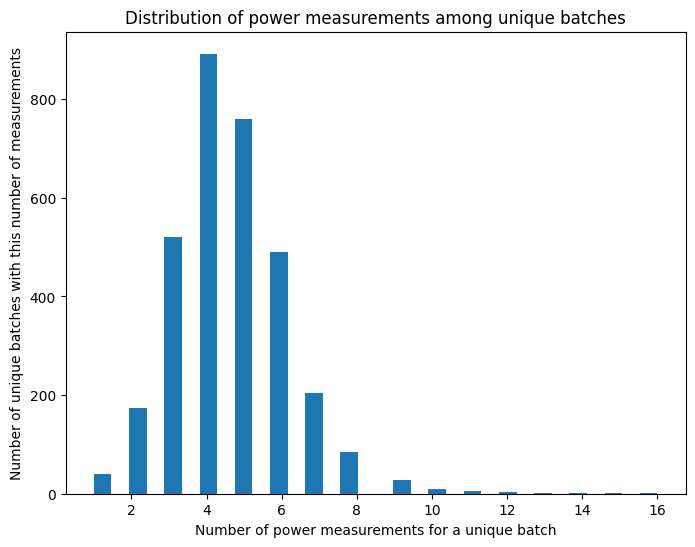

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['key'].value_counts(), bins=32)
plt.xlabel('Number of power measurements for a unique batch')
plt.ylabel('Number of unique batches with this number of measurements')
plt.title('Distribution of power measurements among unique batches')
plt.show()

**We see that the largest number of batches among all data are 4 power measurements.**

**Let's look at the distribution of reactive and active power values, and exclude the anomalous negative value from the reactive values to get a readable graph.**

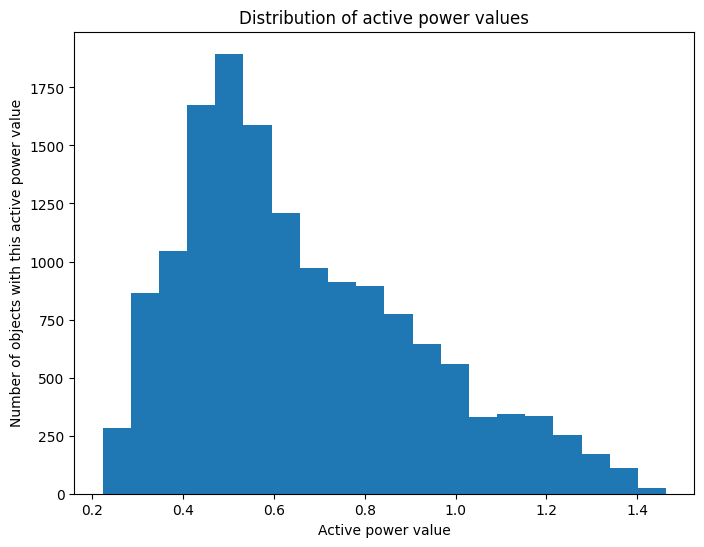

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['Active power'], bins=20)
plt.xlabel('Active power value')
plt.ylabel('Number of objects with this active power value')
plt.title('Distribution of active power values')
plt.show()

**Active power values are normally distributed, the most common value is 0.5.**

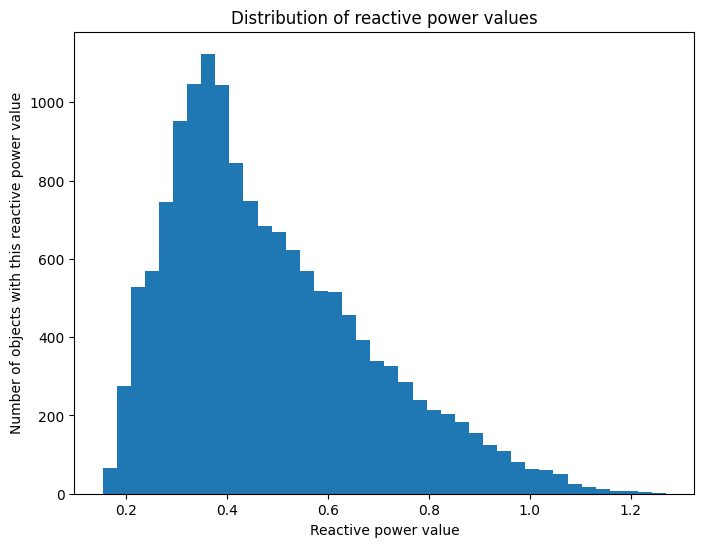

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['Reactive power'][df_dict['arc']['Reactive power'] > 0], bins=40)
plt.xlabel('Reactive power value')
plt.ylabel('Number of objects with this reactive power value')
plt.title('Distribution of reactive power values')
plt.show()

**Reactive power values (excluding the anomalous negative value) are normally distributed, the most common value is less than 0.4.**

**Intermediate conclusions based on the data in the 'arc' dataframe containing the electrode data.**

* There are no gaps in the data in this dataframe.
* In the data on electrodes, there is only one batch with an anomalous value of reactive power - batch 2116.
* Most often in the data there are 4 power measurements for each unique batch.
* Active power values are normally distributed with a peak at 0.5.
* Reactive power values are normally distributed (excluding anomalous negative value) with a peak value just below 0.4.
* The number of parties is 3241, but they are not all represented in this dataframe; there is no data on 27 unique parties.
* From the values of active power and time delta, you can obtain a new indicator - the total active energy for a unique batch.
* From the values of active and reactive power, using the sum for one unique batch, you can obtain new characteristics - the total consumed active and reactive power for a given batch.
* It is necessary to bring the names of signs to the “snake” register and in English.
* It is necessary to change the type of two signs “Start of arc heating” and “End of arc heating” to datetime, because they are responsible for the date and time.

### 2.2 Data on the supply of bulk materials (volume)

In [36]:
info_func(df_dict['bulk'], 'bulk')

Number of gaps in shares in the dataframe "bulk" 

            Null%  Total  Total_Null     Type
key      0.000000   3129           0    int64
Bulk 1   0.919463   3129        2877  float64
Bulk 2   0.992969   3129        3107  float64
Bulk 3   0.585171   3129        1831  float64
Bulk 4   0.675935   3129        2115  float64
Bulk 5   0.975391   3129        3052  float64
Bulk 6   0.815916   3129        2553  float64
Bulk 7   0.992010   3129        3104  float64
Bulk 8   0.999680   3129        3128  float64
Bulk 9   0.993928   3129        3110  float64
Bulk 10  0.943752   3129        2953  float64
Bulk 11  0.943432   3129        2952  float64
Bulk 12  0.217002   3129         679  float64
Bulk 13  0.994247   3129        3111  float64
Bulk 14  0.103228   3129         323  float64
Bulk 15  0.281560   3129         881  float64


First 5 lines in dataframe "bulk" 
 
    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bu

**Visualize the number of real objects in each of the features**

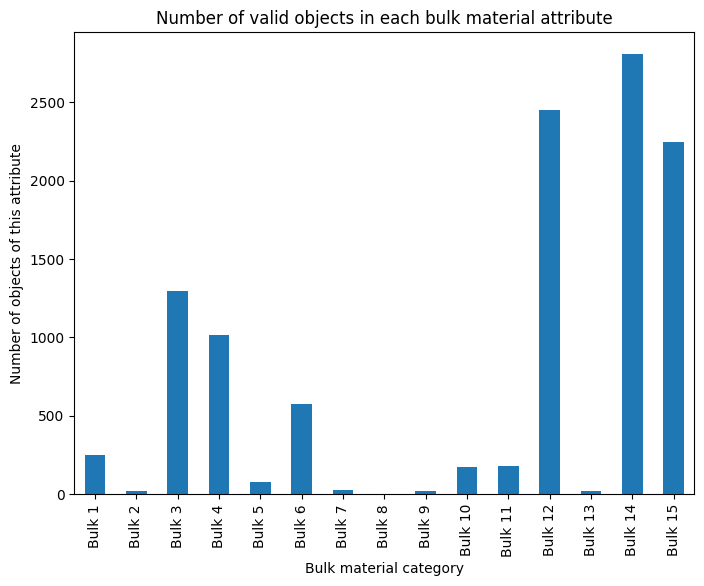

In [37]:
plt.figure(figsize=(8, 6))
ax = df_dict['bulk'].drop('key', axis=1).notnull().sum().plot(kind='bar')
ax.set_title('Number of valid objects in each bulk material attribute')
ax.set_xlabel('Bulk material category')
ax.set_ylabel('Number of objects of this attribute')
plt.show()

In [38]:
bulks_to_del = df_dict['bulk'].drop('key', axis=1) \
                     .notnull().sum().sort_values() \
                     .iloc[0:5].index.to_list()
print(f'List of categories of bulk materials for subsequent deletion: \n{bulks_to_del}')

List of categories of bulk materials for subsequent deletion: 
['Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7']


**We see that the number of actual objects is very small in categories 2, 7, 8, 9, 13. Most likely, to obtain better results during modeling, it will be necessary to exclude these features in the next section.**

**In the data of this dataframe there is a very large number of gaps; most likely this fact may be due to the specifics of the technological process, because Not all types of bulk materials are added for all batches. For this reason, it is most logical to fill in the gaps in this data with zero. We will do this at the next stage of data preprocessing.**

**Let's look at the distribution of data in this dataframe by unique batch number values.**

In [39]:
df_dict['bulk']['key'].value_counts().unique()

array([1])

**There is only one data line for each batch.**

**From the previous subsection we know that the number of unique batches is at least 3241, and in this dataframe we see that the number of batches is 3129. Let’s find out which batches are missing
in this dataframe.**

In [40]:
keys_not_in_bulk = [x for x in list(range(1, 3242)) if x not in df_dict['bulk']['key'].values]
print(f'Numbers of batches missing from dataframe data "bulk": {keys_not_in_bulk}')
print(f'Number of batches missing from dataframe data "bulk": {len(keys_not_in_bulk)}')

Numbers of batches missing from dataframe data "bulk": [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]
Number of batches missing from dataframe data "bulk": 112


**Intermediate conclusions based on data in the 'bulk' dataframe containing data on the supply of bulk materials (volume).**

* Only one set of values appears in the data for each unique batch.
* This dataframe does not contain data for 112 unique batches.
* It is necessary to convert the names of signs to "snake" case.
* There is a very large number of gaps in the data of this dataframe; most likely, this fact may be due to the specifics of the technological process; it is most logical to fill in the gaps in this data with zero.
* The number of actual objects is very small in categories 2, 7, 8, 9, 13 bulk materials. Most likely, to obtain better modeling results, it will be necessary to exclude these features in the next section.

### 2.3 Bulk material supply data (time)

In [41]:
info_func(df_dict['bulk_time'], 'bulk_time')

Number of gaps in shares in the dataframe "bulk_time" 

            Null%  Total  Total_Null    Type
key      0.000000   3129           0   int64
Bulk 1   0.919463   3129        2877  object
Bulk 2   0.992969   3129        3107  object
Bulk 3   0.585171   3129        1831  object
Bulk 4   0.675935   3129        2115  object
Bulk 5   0.975391   3129        3052  object
Bulk 6   0.815916   3129        2553  object
Bulk 7   0.992010   3129        3104  object
Bulk 8   0.999680   3129        3128  object
Bulk 9   0.993928   3129        3110  object
Bulk 10  0.943752   3129        2953  object
Bulk 11  0.943432   3129        2952  object
Bulk 12  0.217002   3129         679  object
Bulk 13  0.994247   3129        3111  object
Bulk 14  0.103228   3129         323  object
Bulk 15  0.281560   3129         881  object


First 5 lines in dataframe "bulk_time" 
 
    key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13      

**The data in this dataframe has a very large number of gaps, similar to the previous dataframe.**

**It is necessary to change the data type to datetime, because all these characteristics except the batch number are responsible for time and date.**

**It is necessary to convert the names of features to the “snake” case.**

**Let's look at the distribution of data in this dataframe by unique batch number values.**

In [42]:
df_dict['bulk_time']['key'].value_counts().unique()

array([1])

**There is only one data line for each batch.**

**From the previous subsection we know that the number of unique batches is at least 3241, and in this dataframe we see that the number of batches is 3129. Let’s find out which batches are missing
in this dataframe.**

In [43]:
keys_not_in_bulk_time = [x for x in list(range(1, 3242)) if x not in df_dict['bulk_time']['key'].values]
print(f'Numbers of batches missing from dataframe data "bulk_time": {keys_not_in_bulk_time}')
print(f'Number of batches missing from dataframe data "bulk_time": {len(keys_not_in_bulk_time)}')

Numbers of batches missing from dataframe data "bulk_time": [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]
Number of batches missing from dataframe data "bulk_time": 112


**Intermediate conclusions based on data in the 'bulk_time' dataframe containing data on the supply of bulk materials (time).**

* Only one set of values appears in the data for each unique batch.
* This dataframe does not contain data for 112 unique batches.
* Convert the type of attributes responsible for date and time (all except key) to datetime.
* It is necessary to convert the names of signs to "snake" case.
* There is a very large number of gaps in the data of this dataframe; most likely, this fact may be due to the specifics of the technological process; it is most logical to fill in the gaps in this data with zero if a decision is made to use this data.

### 2.4 Data on alloy gas purging

In [44]:
info_func(df_dict['gas'], 'gas')

Number of gaps in shares in the dataframe "gas" 

       Null%  Total  Total_Null     Type
key      0.0   3239           0    int64
Gas 1    0.0   3239           0  float64


First 5 lines in dataframe "gas" 
 
    key      Gas 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692 


Description of the distribution in the dataframe "gas" 

               key        Gas 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


Number of complete duplicates in dataframe "gas" = 0


**No data gaps.**

**Let's look at the distribution of data in this dataframe by unique batch number values.**

In [45]:
df_dict['gas']['key'].value_counts().unique()

array([1])

**There is only one data line for each batch.**

**From the previous subsection we know that the number of unique batches is at least 3241, and in this dataframe we see that the number of batches is 3129. Let’s find out which batches are missing
in this dataframe.**

In [46]:
keys_not_in_gas = [x for x in list(range(1, 3242)) if x not in df_dict['gas']['key'].values]
print(f'Numbers of batches missing from dataframe data "gas": {keys_not_in_gas}')
print(f'Number of batches missing from dataframe data "gas": {len(keys_not_in_gas)}')

Numbers of batches missing from dataframe data "gas": [193, 259]
Number of batches missing from dataframe data "gas": 2


**Let's look at the distribution of the volume of purging gas in the dataframe.**

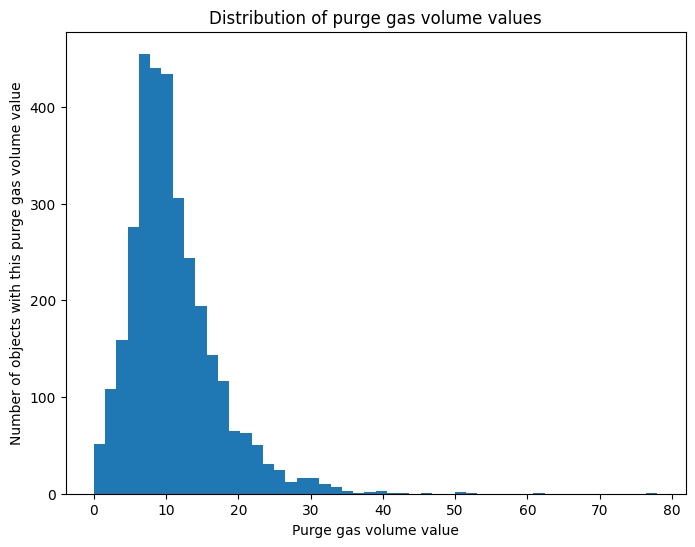

In [47]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['gas']['Gas 1'], bins=50)
plt.xlabel('Purge gas volume value')
plt.ylabel('Number of objects with this purge gas volume value')
plt.title('Distribution of purge gas volume values')
plt.show()

**We see a normal distribution of values with a peak at value 10.**

**Intermediate conclusions based on data in the 'gas' dataframe containing data on the alloy being purged with gas.**

* Only one set of values appears in the data for each unique batch.
* This dataframe does not contain data for 2 unique batches.
* The distribution of gas volume values is normal with a peak at value 10.
* It is necessary to convert the name of the trait to the “snake” case in English.
* There are no gaps in the data in this dataframe.

### 2.5 Temperature measurement data

In [48]:
info_func(df_dict['temp'], 'temp')

Number of gaps in shares in the dataframe "temp" 

                     Null%  Total  Total_Null     Type
key               0.000000  18092           0    int64
Measurement time  0.000000  18092           0   object
Temperature       0.189421  18092        3427  float64


First 5 lines in dataframe "temp" 
 
    key     Measurement time  Temperature
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0 


Description of the distribution in the dataframe "temp" 

                key   Temperature
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


Number of complete duplicates in dataframe "temp" = 0


**There are approximately 19% missing temperature data among all data. According to the initial conditions of the problem, we believe that in case of gaps in this variable, this means a failure of the sensor, and it is necessary not to use data associated with those unique batches where these failures/gaps in data were observed.**

**It will be necessary to subsequently change the type of the “Measurement time” attribute to datetime, because this attribute is responsible for the date and time.**

**In addition, for ease of use, the names of the features must be translated into English. name and "snake" register.**

** Because If we need to predict temperature from multiple values, then data corresponding to batches for which there is only one temperature measurement must also be excluded from our analysis.**

**According to the conditions of the problem, it is necessary to use only the first temperature measurement as a characteristic, and the last temperature measurement for a unique batch as a target characteristic.**

** Because The melting temperature of steel is in the range [1450; 1520], then data that corresponds to a temperature below the left border must be deleted - these are anomalous values that do not correspond to the technological process.**

**Let's see how many games have anomalous values.**

In [49]:
# Determine the batch numbers for which there are gaps in temperature measurements
keys_temp_isnull = list(df_dict['temp'][df_dict['temp']['Temperature'].isnull()]['key'].unique())
print(f'Number of unique batch numbers with gaps in temperature measurements \
= {len(keys_temp_isnull)}')
print(f'List of unique values for these batch numbers: {keys_temp_isnull}')

Number of unique batch numbers with gaps in temperature measurements = 739
List of unique values for these batch numbers: [2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2

In [50]:
#let's add to the previously created list with the number of batches that need to be excluded from the analysis

keys_to_del += keys_temp_isnull
print(f'Number of elements in the list with batch numbers to be deleted = {len(keys_to_del)}')

Number of elements in the list with batch numbers to be deleted = 740


In [51]:
# Determine the batch numbers for which there is only one temperature measurement
single_temp = df_dict['temp']['key'].value_counts().reset_index()
keys_temp_single = single_temp[single_temp['key'] == 1]['index'].to_list()
print(f'Number of unique batch numbers with one temperature measurement \
  = {len(keys_temp_single)}')
print(f'List of unique values for these batch numbers: {keys_temp_single}')

Number of unique batch numbers with one temperature measurement   = 2
List of unique values for these batch numbers: [195, 279]


In [52]:
#let's add to the previously created list with the number of batches that need to be excluded from the analysis

keys_to_del += keys_temp_single
print(f'Number of elements in the list with batch numbers to be deleted = {len(keys_to_del)}')

Number of elements in the list with batch numbers to be deleted = 742


In [53]:
# Let's determine the batch numbers for which the temperature value
# below the known melting temperature of steel, i.e. below 1450
keys_temp_below_boiling = list(df_dict['temp'][df_dict['temp']['Temperature'] < 1450]['key'].unique())
print(f'Number of unique batch numbers with low temperature \
= {len(keys_temp_below_boiling)}')
print(f'List of unique values for these batch numbers: {keys_temp_below_boiling}')

Number of unique batch numbers with low temperature = 5
List of unique values for these batch numbers: [867, 1214, 1619, 2052, 2561]


In [54]:
#let's add to the previously created list with the number of batches that need to be excluded from the analysis

keys_to_del += keys_temp_below_boiling
print(f'Number of elements in the list with batch numbers to be deleted = {len(keys_to_del)}')

Number of elements in the list with batch numbers to be deleted = 747


In [55]:
# some batch numbers could be included in this list several times, let's leave only unique ones\
unique_keys_to_del = list(set(keys_to_del))
print(f'Number of elements in the list with unique batch numbers to be deleted = {len(unique_keys_to_del)}')

Number of elements in the list with unique batch numbers to be deleted = 746


**We see that the maximum value of the batch number is 3241. Let's check whether all batch numbers from 1 to 3241 are actually represented in the data in this dataframe.**

In [56]:
len(df_dict['temp']['key'].unique())

3216

**The length of unique lot number values is not 3241, which means that not all lot numbers are represented in this dataframe. Let's check which ones are missing.**

In [57]:
keys_not_in_temp = [x for x in list(range(1, 3242)) if x not in df_dict['temp']['key'].values]
print(f'Numbers of batches missing from dataframe data "temp": {keys_not_in_temp}')
print(f'Number of batches missing from dataframe data "temp": {len(keys_not_in_temp)}')

Numbers of batches missing from dataframe data "temp": [41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]
Number of batches missing from dataframe data "temp": 25


**Let's look at the distribution of temperature measurements among all batches.**

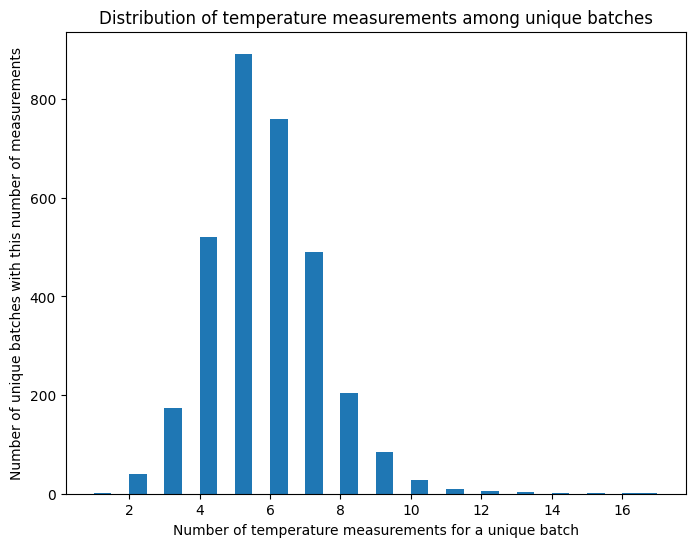

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['temp']['key'].value_counts(), bins=32)
plt.xlabel('Number of temperature measurements for a unique batch')
plt.ylabel('Number of unique batches with this number of measurements')
plt.title('Distribution of temperature measurements among unique batches')
plt.show()

**We see that the largest number of batches among all data have 5 temperature measurements.**

**Intermediate conclusions based on data in the 'temp' dataframe containing temperature measurement data.**

* There are about 19% gaps in the data in this dataframe.
* The temperature data contains a total of 746 unique batches that require exclusion from subsequent analysis for reasons: omissions in the data, a single measurement, temp. value. lower temp. melting steel.
* Most often, the data contains 5 temperature measurements for each unique batch.
* The number of parties is 3241, but they are not all represented in this dataframe; there is no data on 25 unique parties.
* It is necessary to bring the names of signs to the “snake” register and in English.
* It is necessary to change the attribute type "Time measurements" to datetime, because they are responsible for the date and time.
* It is necessary to use only the first temperature measurement as a sign, and the last temperature measurement for a unique batch as a target sign.

### 2.6 Wire material data (volume)

In [59]:
info_func(df_dict['wire'], 'wire')

Number of gaps in shares in the dataframe "wire" 

           Null%  Total  Total_Null     Type
key     0.000000   3081           0    int64
Wire 1  0.008439   3081          26  float64
Wire 2  0.649789   3081        2002  float64
Wire 3  0.979552   3081        3018  float64
Wire 4  0.995456   3081        3067  float64
Wire 5  0.999675   3081        3080  float64
Wire 6  0.976306   3081        3008  float64
Wire 7  0.996430   3081        3070  float64
Wire 8  0.993833   3081        3062  float64
Wire 9  0.990587   3081        3052  float64


First 5 lines in dataframe "wire" 
 
    key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN

**Visualize the number of real objects in each of the features**

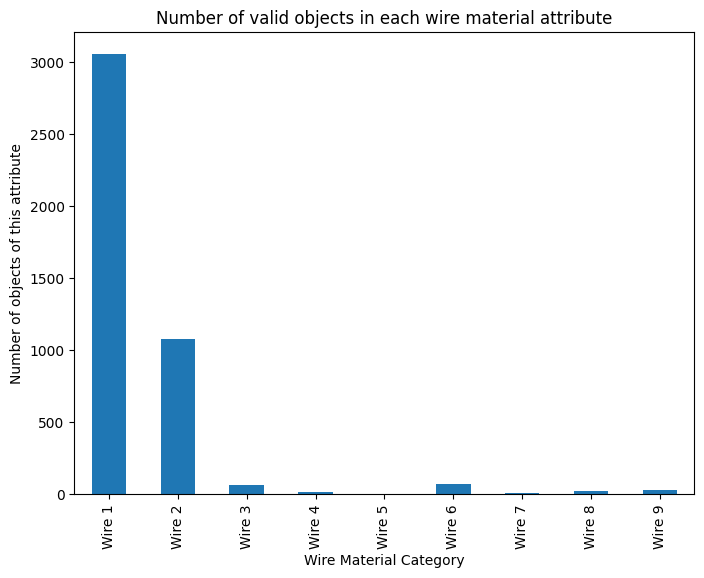

In [60]:
plt.figure(figsize=(8, 6))
ax = df_dict['wire'].drop('key', axis=1).notnull().sum().plot(kind='bar')
ax.set_title('Number of valid objects in each wire material attribute')
ax.set_xlabel('Wire Material Category')
ax.set_ylabel('Number of objects of this attribute')
plt.show()

In [61]:
wires_to_del = df_dict['wire'].drop('key', axis=1) \
                     .notnull().sum().sort_values() \
                     .iloc[0:5].index.to_list()
print(f'List of categories of wire materials to be deleted: \n{wires_to_del}')

List of categories of wire materials to be deleted: 
['Wire 5', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9']


**We see that the number of actual objects is very small in categories 4, 5, 7, 8, 9. Most likely, to obtain better results during modeling, it will be necessary to exclude these features in the next section.**


**In the data of this dataframe there is a very large number of gaps; most likely this fact may be due to the specifics of the technological process, because Not all types of wire materials are added for all batches. For this reason, it is most logical to fill in the gaps in this data with zero. We will do this at the next stage of data preprocessing.**

**Let's look at the distribution of data in this dataframe by unique batch number values.**

In [62]:
df_dict['wire']['key'].value_counts().unique()

array([1])

**There is only one data line for each batch.**

**From the previous subsection we know that the number of unique batches is at least 3241, and in this dataframe we see that the number of batches is 3081. Let’s find out which batches are missing
in this dataframe.**

In [63]:
keys_not_in_wire = [x for x in list(range(1, 3242)) if x not in df_dict['wire']['key'].values]
print(f'Numbers of batches missing from dataframe data "wire": {keys_not_in_wire}')
print(f'Number of batches missing from dataframe data "wire": {len(keys_not_in_wire)}')

Numbers of batches missing from dataframe data "wire": [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]
Number of batches missing from dataframe data "wire": 160

**Intermediate conclusions based on data in the 'wire' dataframe containing data on the supply of wire materials (volume).**

* Only one set of values appears in the data for each unique batch.
* This dataframe does not contain data for 160 unique batches.
* It is necessary to convert the names of signs to "snake" case.
* There is a very large number of gaps in the data of this dataframe; most likely, this fact may be due to the specifics of the technological process; it is most logical to fill in the gaps in this data with zero.
* The number of actual objects is very small in categories 4, 5, 7, 8, 9 wire materials. Most likely, to obtain better modeling results, it will be necessary to exclude these features in the next section.

### 2.7 Wire material data (time)

In [64]:
info_func(df_dict['wire_time'], 'wire_time')

Number of gaps in shares in the dataframe "wire_time" 

           Null%  Total  Total_Null    Type
key     0.000000   3081           0   int64
Wire 1  0.008439   3081          26  object
Wire 2  0.649789   3081        2002  object
Wire 3  0.979552   3081        3018  object
Wire 4  0.995456   3081        3067  object
Wire 5  0.999675   3081        3080  object
Wire 6  0.976306   3081        3008  object
Wire 7  0.996430   3081        3070  object
Wire 8  0.993833   3081        3062  object
Wire 9  0.990587   3081        3052  object


First 5 lines in dataframe "wire_time" 
 
    key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
3    4  2019-05-03 12:4

**The data in this dataframe has a very large number of gaps, similar to the previous dataframe.**

**It is necessary to change the data type to datetime, because all these characteristics except the batch number are responsible for time and date.**

**It is necessary to convert the names of features to the “snake” case.**

**Let's look at the distribution of data in this dataframe by unique batch number values.**

In [65]:
df_dict['wire_time']['key'].value_counts().unique()

array([1])

**There is only one data line for each batch.**

**From the previous subsection we know that the number of unique batches is at least 3241, and in this dataframe we see that the number of batches is 3081. Let’s find out which batches are missing
in this dataframe.**

In [66]:
keys_not_in_wire_time = [x for x in list(range(1, 3242)) if x not in df_dict['wire_time']['key'].values]
print(f'Batch numbers missing from dataframe data "wire_time": {keys_not_in_wire_time}')
print(f'Number of batches missing from dataframe data "wire_time": {len(keys_not_in_wire_time)}')

Batch numbers missing from dataframe data "wire_time": [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]
Number of batches missing from dataframe data "wire_time"

**Intermediate conclusions based on the data in the 'wire_time' dataframe containing data on the supply of wire materials (time).**

* Only one set of values appears in the data for each unique batch.
* This dataframe does not contain data for 160 unique batches.
* Convert the type of attributes responsible for date and time (all except key) to datetime.
* It is necessary to convert the names of signs to "snake" case.
* There is a very large number of gaps in the data of this dataframe; most likely, this fact may be due to the specifics of the technological process; it is most logical to fill in the gaps in this data with zero if a decision is made to use this data.

### 2.8 Main conclusions of the section in the key to the further data preprocessing plan
* Do not use data on the feeding time of bulk materials and wire materials, because We do not use time series and the influence of this data on the target attribute cannot be great; we will limit ourselves only to data on the data volumes of two types of materials.
* From all further used dataframes we delete data that corresponds to batch numbers from the generated list for deletion, due to anomalous values and gaps in temperature.
* Due to the small number of actual objects, we exclude from further analysis signs 4, 5, 7, 8, 9 wire materials and 2, 7, 8, 9, 13 bulk materials in the next section.
* Gaps in the data on the supply of bulk and wire materials are filled in with 0.
* It is necessary to change the type of some features and rename them in accordance with the “snake” register in English. language.
* Creation of new features: active energy for each unique batch, as well as total power, both active and reactive, for each unique batch.
* Of the temperature data, only the first temperature measurement should be used as a characteristic, and the last temperature measurement for a unique batch should be used as a target characteristic.
* Data merging will occur based on the key attribute - batch number.
* There are no questions to the customer at the moment, the introductory technological process is clear.

## 3. Data preprocessing

### 3.1 Deleting data associated with selected batches

**We act based on the main conclusions after studying the data above.**

**Let's create a new dataframe dictionary without two dataframes wire_time and bulk_time, because we exclude them from further work. We will remove from the dataframe data information about batches that are not suitable for subsequent analysis and modeling.**

In [67]:
#create a new dictionary with filtered dataframes
df_dict_f = {key: value for key, value in df_dict.items() if key not in ['bulk_time', 'wire_time']}

#delete records associated with filtered batches
for key in df_dict_f:
     print(f'Size of dataframe "{key}" before deleting batches: {df_dict[key].shape}')
     df_dict_f[key] = df_dict_f[key][~df_dict_f[key]['key'].isin(unique_keys_to_del)]
     print(f'Size of dataframe "{key}" after deleting batches: {df_dict_f[key].shape} \n')
     print(f'First lines of dataframe "{key}" after deleting batches: \n{df_dict_f[key].head(2)}\n', '-'*75)

Size of dataframe "arc" before deleting batches: (14876, 5)
Size of dataframe "arc" after deleting batches: (11428, 5) 

First lines of dataframe "arc" after deleting batches: 
   key Start of arc heating   End of arc heating  Active power  Reactive power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130        0.211253
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658        0.477438
 ---------------------------------------------------------------------------
Size of dataframe "bulk" before deleting batches: (3129, 16)
Size of dataframe "bulk" after deleting batches: (2402, 16) 

First lines of dataframe "bulk" after deleting batches: 
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN     NaN      NaN      NaN    206.0      NaN    150.0    154.0
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN 

### 3.2 Removing unnecessary features

**We will exclude from the dataframes about bulk and wire materials the features that correspond to the selected categories with a small number of objects.**

In [68]:
def drop_col(key, list_col):
     print(f'Characteristics in the dataframe "{key}" before deletion: \n{df_dict_f[key].columns.to_list()}\n')
     print(f'Size of dataframe "{key}" before deletion: {df_dict_f[key].shape}')
     df_dict_f[key] = df_dict_f[key].drop(list_col, axis=1)
     print(f'Size of dataframe "{key}" after deletion: {df_dict_f[key].shape} \n')
     print(f'First lines of dataframe "{key}" after deletion: \n{df_dict_f[key].head(2)}\n', '-'*75)
     return

drop_col('bulk', bulks_to_del)
drop_col('wire', wires_to_del)

Characteristics in the dataframe "bulk" before deletion: 
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

Size of dataframe "bulk" before deletion: (2402, 16)
Size of dataframe "bulk" after deletion: (2402, 11) 

First lines of dataframe "bulk" after deletion: 
   key  Bulk 1  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 10  Bulk 11  Bulk 12  Bulk 14  Bulk 15
0    1     NaN     NaN    43.0     NaN     NaN      NaN      NaN    206.0    150.0    154.0
1    2     NaN     NaN    73.0     NaN     NaN      NaN      NaN    206.0    149.0    154.0
 ---------------------------------------------------------------------------
Characteristics in the dataframe "wire" before deletion: 
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

Size of dataframe "wire" before deletion: (2367, 10)
Size of dataframe "wire" after deletion: (2367, 5) 

First

### 3.3 Filling gaps in data

**Let us now fill in the gaps in the data on bulk and wire materials with zero values.**

In [69]:
for key in ['bulk', 'wire']:
     print(f'Total number of omissions in all features '
           f'dataframe "{key}" = {df_dict_f[key].isna().sum().sum()}')
     print(f'Size of dataframe "{key}" before gap filling: {df_dict_f[key].shape} \n')
     df_dict_f[key] = df_dict_f[key].fillna(0)
     print(f'Total number of gaps in all features of the dataframe '
           f'"{key}" after filling in the blanks = {df_dict_f[key].isna().sum().sum()}')
     print(f'Size of dataframe "{key}" after filling in the blanks: {df_dict_f[key].shape} \n')
     print(f'First lines of the dataframe "{key}" after filling in the gaps: \n{df_dict_f[key].head(2)}\n', '-'*75)

Total number of omissions in all features dataframe "bulk" = 15555
Size of dataframe "bulk" before gap filling: (2402, 11) 

Total number of gaps in all features of the dataframe "bulk" after filling in the blanks = 0
Size of dataframe "bulk" after filling in the blanks: (2402, 11) 

First lines of the dataframe "bulk" after filling in the gaps: 
   key  Bulk 1  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 10  Bulk 11  Bulk 12  Bulk 14  Bulk 15
0    1     0.0     0.0    43.0     0.0     0.0      0.0      0.0    206.0    150.0    154.0
1    2     0.0     0.0    73.0     0.0     0.0      0.0      0.0    206.0    149.0    154.0
 ---------------------------------------------------------------------------
Total number of omissions in all features dataframe "wire" = 6210
Size of dataframe "wire" before gap filling: (2367, 5) 

Total number of gaps in all features of the dataframe "wire" after filling in the blanks = 0
Size of dataframe "wire" after filling in the blanks: (2367, 5) 

First lines of t

### 3.4 Renaming features

**We present the names of the features in accordance with the “snake” register in English. language.**

In [71]:
print(f'Characters in the dataframe "arc" before renaming: \n{df_dict_f["arc"].columns.to_list()}\n')
print(f'Size of dataframe "arc" before gap filling: {df_dict_f["arc"].shape}')
df_dict_f['arc'] = df_dict_f['arc'].rename(columns={'Start of arc heating': 'start_heat_time',
                                  'End of arc heating': 'end_heat_time',
                                  'Active power': 'active_power',
                                  'Reactive power': 'reactive_power'})
print(f'Size of dataframe "arc" after renaming: {df_dict_f["arc"].shape} \n')
print(f'First lines of dataframe "arc" after renaming: \n{df_dict_f["arc"].head(2)}\n', '-'*75)

print(f'Features in the dataframe "gas" before renaming: \n{df_dict_f["gas"].columns.to_list()}\n')
print(f'Size of dataframe "gas" before renaming: {df_dict_f["gas"].shape}')
df_dict_f['gas'] = df_dict_f['gas'].rename(columns={'Gas 1': 'gas1'})
print(f'Size of dataframe "gas" after renaming: {df_dict_f["gas"].shape} \n')
print(f'First lines of dataframe "gas" after renaming: \n{df_dict_f["gas"].head(2)}\n', '-'*75)

print(f'Characters in the dataframe "temp" before renaming: \n{df_dict_f["temp"].columns.to_list()}\n')
print(f'Size of dataframe "temp" before renaming: {df_dict_f["temp"].shape}')
df_dict_f['temp'] = df_dict_f['temp'].rename(columns={'Measurement time': 'meas_time',
                                  'Temperature': 'temperature'})
print(f'Size of dataframe "temp" after renaming: {df_dict_f["temp"].shape} \n')
print(f'First lines of dataframe "temp" after renaming: \n{df_dict_f["temp"].head(2)}\n', '-'*75)

def ren_col_del_space(key):
     col_dict = {}
     for col in df_dict_f[key].columns.to_list():
         col_dict[col] = "".join(col.split()).lower()
     print(f'Characteristics in the dataframe "{key}" before renaming: \n{df_dict_f[key].columns.to_list()}\n')
     print(f'Size of dataframe "{key}" before renaming: {df_dict_f[key].shape}')
     df_dict_f[key] = df_dict_f[key].rename(columns=col_dict)
     print(f'Size of dataframe "{key}" after renaming: {df_dict_f[key].shape} \n')
     print(f'First lines of dataframe "{key}" after renaming: \n{df_dict_f[key].head(2)}\n', '-'*75)
     return

ren_col_del_space('bulk')
ren_col_del_space('wire')

Characters in the dataframe "arc" before renaming: 
['key', 'start_heat_time', 'end_heat_time', 'active_power', 'reactive_power']

Size of dataframe "arc" before gap filling: (11428, 5)
Size of dataframe "arc" after renaming: (11428, 5) 

First lines of dataframe "arc" after renaming: 
   key      start_heat_time        end_heat_time  active_power  reactive_power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130        0.211253
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658        0.477438
 ---------------------------------------------------------------------------
Features in the dataframe "gas" before renaming: 
['key', 'gas1']

Size of dataframe "gas" before renaming: (2493, 2)
Size of dataframe "gas" after renaming: (2493, 2) 

First lines of dataframe "gas" after renaming: 
   key       gas1
0    1  29.749986
1    2  12.555561
 ---------------------------------------------------------------------------
Characters in the dataframe "temp" before renaming

### 3.5 Casting data types to the correct ones

**We will make appropriate changes to data types in a number of dataframes.**

In [72]:
def col_to_datetime(key, col_list):
     if isinstance(col_list, str):
         col_list = [col_list]
     for col in col_list:
         df_dict_f[key][col] = pd.to_datetime(df_dict_f[key].copy()[col])
     print(f'Size of dataframe "{key}" before changing types: {df_dict_f[key].shape}')
     print(f'Size of dataframe "{key}" after changing types: {df_dict_f[key].shape} \n')
     print(f'Feature types in dataframe "{key}" after update: \n{df_dict_f[key].dtypes}\n')
     print(f'First lines of dataframe "{key}" after changing types: \n{df_dict_f[key].head(2)}\n', '-'*75)
     return

col_to_datetime('arc', ['start_heat_time', 'end_heat_time'])
col_to_datetime('temp', 'meas_time')

Size of dataframe "arc" before changing types: (11428, 5)
Size of dataframe "arc" after changing types: (11428, 5) 

Feature types in dataframe "arc" after update: 
key                         int64
start_heat_time    datetime64[ns]
end_heat_time      datetime64[ns]
active_power              float64
reactive_power            float64
dtype: object

First lines of dataframe "arc" after changing types: 
   key     start_heat_time       end_heat_time  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
 ---------------------------------------------------------------------------
Size of dataframe "temp" before changing types: (13898, 3)
Size of dataframe "temp" after changing types: (13898, 3) 

Feature types in dataframe "temp" after update: 
key                     int64
meas_time      datetime64[ns]
temperature           float64
dtype: object

First lines of 

### 3.6 Creating new features

**After applying all the changes, we will work with the “arc” dataframe, namely: we will create new signs - the total expended active energy for each unique batch, as well as the total active and reactive power for each unique batch.**

**Obviously, for heating steel in a ladle, the indicated power values ​​are measured in MW, accordingly, the obtained active energy by multiplying the active power by the time delta in seconds will be expressed in MJ.**

In [73]:
#create a new variable - time delta
df_dict_f['arc']['delta_time'] = df_dict_f['arc']['end_heat_time'] - df_dict_f['arc']['start_heat_time']

#create a new variable - time delta in seconds
df_dict_f['arc']['seconds'] = (df_dict_f['arc']['delta_time'].astype(int) / 10**9).astype(int)

# create a new variable - active energy in MJ
df_dict_f['arc']['active_energy'] = df_dict_f['arc']['active_power'] * df_dict_f['arc']['seconds']

# group by batch number and find the total values of active and reactive power,
#as well as active energy for each unique batch
df_dict_f['arc_new'] = df_dict_f['arc'].copy()[['key', 'active_power', 'reactive_power', 'active_energy']] \
       .groupby('key').sum().reset_index()
print(f'Size of dataframe "arc" before data aggregation: {df_dict_f["arc"].shape} \n')
print(f'Size of dataframe "arc_new" after data aggregation: {df_dict_f["arc_new"].shape} \n')
print(f'First lines of dataframe "arc_new" after data aggregation: \n{df_dict_f["arc_new"].head(3)}')

Size of dataframe "arc" before data aggregation: (11428, 8) 

Size of dataframe "arc_new" after data aggregation: (2470, 4) 

First lines of dataframe "arc_new" after data aggregation: 
   key  active_power  reactive_power  active_energy
0    1      3.036730        2.142821     628.616930
1    2      2.139408        1.453357     395.281800
2    3      4.063641        2.937457     581.774624


**From a dataframe with temperature data, only the first temperature measurement should be used as a feature, and the last temperature measurement for a unique batch should be used as a target feature. Let's create a new dataframe with aggregated data.**

**First, let's check if there are any duplicate time and date values in the data.**

In [74]:
print(f'Number of duplicates in the attribute "meas_time" = {df_dict_f["temp"]["meas_time"].duplicated().sum()}')

Number of duplicates in the attribute "meas_time" = 0


In [75]:
#group by batch number and apply the minimum and maximum function measurement time to the attribute,
#remove the batch number attribute, because later it will be combined with the original dataframe, which will not repeat the key attribute
df_gr = df_dict_f['temp'].copy().groupby('key')['meas_time'].agg(['min', 'max']).reset_index().drop('key', axis= 1)

#merge by date/time tag, because there are no duplicates in this attribute
temp_x = pd.merge(df_dict_f['temp'], df_gr, left_on='meas_time', right_on='min')
temp_y = pd.merge(df_dict_f['temp'], df_gr, left_on='meas_time', right_on='max')

#merge into a single new dataframe, where temp_x is a feature, and temp_y is a target feature
df_dict_f['temp_new'] = pd.merge(temp_x, temp_y, on='key')[['key','temperature_x', 'temperature_y']]

print(f'Size of the new received dataframe "temp_new": {df_dict_f["temp_new"].shape}\n')
print(f'First 2 lines of dataframe "temp_new": \n{df_dict_f["temp_new"].head(2)}\n')
print(f'First 7 lines of dataframe "temp": \n{df_dict_f["temp"].head(7)}\n')

Size of the new received dataframe "temp_new": (2470, 3)

First 2 lines of dataframe "temp_new": 
   key  temperature_x  temperature_y
0    1         1571.0         1613.0
1    2         1581.0         1602.0

First 7 lines of dataframe "temp": 
   key           meas_time  temperature
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
5    1 2019-05-03 11:30:38       1613.0
6    2 2019-05-03 11:34:04       1581.0



**From the first batch you can see that the data aggregation was performed correctly.**

**In the created new dataframe 'temp_new': temperature_x - attribute, temperature_y - target attribute.**

**Now we will combine all the new dataframes into a single common one, we will do the union by batch number - the key attribute.**

### 3.7 Creating new aggregated dataframes and analyzing them

In [76]:
#now create a list with the names of dataframes, which we will further combine
list_keys = [x for x in list(df_dict_f) if x not in ['arc', 'temp', 'bulk']]

#create a new dataframe with which we will further combine all the others
df = df_dict_f['bulk']

for key in list_keys:
     df = df.merge(df_dict_f[key], on='key')

#remove the batch number from the final dataframe, because now it is useless and was needed only to generate the final data frame
df = df.drop('key', axis=1)

print(f'Size of final dataframe "df": {df.shape}')
print(f'Information about the final dataframe "df", which we will use for modeling: \n')
df.info()

Size of final dataframe "df": (2324, 20)
Information about the final dataframe "df", which we will use for modeling: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bulk1           2324 non-null   float64
 1   bulk3           2324 non-null   float64
 2   bulk4           2324 non-null   float64
 3   bulk5           2324 non-null   float64
 4   bulk6           2324 non-null   float64
 5   bulk10          2324 non-null   float64
 6   bulk11          2324 non-null   float64
 7   bulk12          2324 non-null   float64
 8   bulk14          2324 non-null   float64
 9   bulk15          2324 non-null   float64
 10  gas1            2324 non-null   float64
 11  wire1           2324 non-null   float64
 12  wire2           2324 non-null   float64
 13  wire3           2324 non-null   float64
 14  wire6           2324 non-null   float64
 15  acti

In [77]:
print('Print descriptive statistics for the combined dataframe:')
df.describe()

Print descriptive statistics for the combined dataframe:


,bulk1,bulk3,bulk4,bulk5,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,gas1,wire1,wire2,wire3,wire6,active_power,reactive_power,active_energy,temperature_x,temperature_y
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,3.435026,47.317126,37.347676,2.645869,22.419535,5.063683,4.254303,208.597676,153.952668,120.078313,11.378854,102.423900,17.613213,3.241876,0.980926,3.126327,2.301280,539.381127,1587.368761,1593.372633
std,12.424463,75.238050,58.677890,22.426054,55.792509,20.938984,22.538843,157.112117,81.410544,84.655967,6.397008,43.540975,33.648176,27.972523,8.702531,1.220484,0.903711,257.301093,23.627590,11.207457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.267676,0.196228,26.187544,1519.000000,1541.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,7.282534,73.204559,0.000000,0.000000,0.000000,2.295960,1.671099,368.304687,1571.000000,1587.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,10.100687,101.103600,0.000000,0.000000,0.000000,3.036517,2.225900,508.538758,1587.000000,1593.000000
75%,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,283.000000,204.000000,204.000000,14.218487,128.075222,23.102560,0.000000,0.000000,3.834302,2.829179,679.198659,1603.000000,1598.000000
max,185.000000,454.000000,281.000000,603.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,180.454575,12.375636,8.949049,3718.054401,1660.000000,1653.000000


In [78]:
print(f'First lines of the merged dataframe "df": \n{df.head()}')

First lines of the merged dataframe "df": 
   bulk1  bulk3  bulk4  bulk5  bulk6  bulk10  bulk11  bulk12  bulk14  bulk15       gas1      wire1    wire2  wire3  wire6  active_power  reactive_power  active_energy  temperature_x  temperature_y
0    0.0    0.0   43.0    0.0    0.0     0.0     0.0   206.0   150.0   154.0  29.749986  60.059998  0.00000    0.0    0.0      3.036730        2.142821     628.616930         1571.0         1613.0
1    0.0    0.0   73.0    0.0    0.0     0.0     0.0   206.0   149.0   154.0  12.555561  96.052315  0.00000    0.0    0.0      2.139408        1.453357     395.281800         1581.0         1602.0
2    0.0    0.0   34.0    0.0    0.0     0.0     0.0   205.0   152.0   153.0  28.554793  91.160157  0.00000    0.0    0.0      4.063641        2.937457     581.774624         1596.0         1599.0
3    0.0    0.0   81.0    0.0    0.0     0.0     0.0   207.0   153.0   154.0  18.841219  89.063515  0.00000    0.0    0.0      2.706489        2.056992     543.710274   

**There are no gaps in the data, all data looks correct.**

**As a result, we received 19 features and 1 target feature.**

**Number of objects for modeling = 2324, which is quite a bit; against the background of a small number of objects, a not very good prediction result may be obtained, we will check further.**

**Feature values are very different from each other; to get a good result when using linear regression, you will need to scale these features.**

**We will display data on the correlation of features in the final dataframe.**

In [ ]:
df.corr()

,bulk1,bulk3,bulk4,bulk5,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,gas1,wire1,wire2,wire3,wire6,active_power,reactive_power,active_energy,temperature_x,temperature_y
bulk1,1.000000,-0.011538,0.041662,0.060365,-0.003581,-0.023333,-0.038008,0.325724,0.207606,-0.001211,0.234089,0.013823,-0.009261,0.020204,0.148509,0.099145,0.095677,0.095641,0.079098,-0.075428
bulk3,-0.011538,1.000000,-0.295526,-0.006766,0.066316,-0.085266,-0.007383,0.018059,0.011209,-0.013181,0.059665,0.037788,0.094897,0.005840,0.007174,0.101267,0.099018,0.088805,-0.113380,-0.037156
bulk4,0.041662,-0.295526,1.000000,0.028273,-0.251577,-0.084975,-0.119733,0.105190,-0.091103,0.100833,0.017532,0.298145,-0.268115,-0.039326,-0.011507,0.005013,0.004137,-0.020899,0.165484,0.187817
bulk5,0.060365,-0.006766,0.028273,1.000000,-0.021853,-0.028544,-0.015888,-0.072951,-0.066101,-0.067426,0.086869,-0.013454,-0.013811,0.070889,0.204796,0.073228,0.072459,0.019551,0.078729,-0.028446
bulk6,-0.003581,0.066316,-0.251577,-0.021853,1.000000,-0.097218,0.196983,-0.112169,0.176791,-0.108626,0.139574,-0.235445,0.205432,-0.046545,-0.020223,0.133855,0.133025,0.148159,-0.127046,-0.180906
bulk10,-0.023333,-0.085266,-0.084975,-0.028544,-0.097218,1.000000,-0.045666,0.027651,-0.045880,0.051953,-0.008634,0.062892,-0.103828,-0.028039,-0.017860,0.010281,0.008439,-0.007075,0.035789,0.061227
bulk11,-0.038008,-0.007383,-0.119733,-0.015888,0.196983,-0.045666,1.000000,-0.040419,0.077966,-0.048571,0.041945,-0.117798,0.062074,-0.021878,0.008655,0.065809,0.064032,0.068808,-0.110430,-0.114936
bulk12,0.325724,0.018059,0.105190,-0.072951,-0.112169,0.027651,-0.040419,1.000000,0.481609,0.613870,0.216969,0.170812,-0.098208,-0.120697,-0.042895,0.285153,0.284874,0.421033,-0.079574,0.266805
bulk14,0.207606,0.011209,-0.091103,-0.066101,0.176791,-0.045880,0.077966,0.481609,1.000000,0.264903,0.268284,-0.052654,0.037017,-0.009010,-0.052578,0.299659,0.295609,0.406902,-0.179991,0.114893
bulk15,-0.001211,-0.013181,0.100833,-0.067426,-0.108626,0.051953,-0.048571,0.613870,0.264903,1.000000,0.043033,0.119047,-0.096411,-0.118355,-0.032618,0.168583,0.166967,0.272895,-0.062382,0.265772


**The number of features in the data is quite large, so the information about the correlation is unreadable, we will correct this by creating a dictionary in which each of the features will be the key, and the key will correspond to a table with the top features modulo the correlation value with the key feature and the value of this correlation without the module .**

In [79]:
data_corr = df.corr() #correlation matrix based on data in df
col_list = data_corr.columns.to_list()
dict_top_corr_data = {} #dictionary with keys by parameter names containing top correlations with other parameters

for column in data_corr.columns: # loop through the columns in the correlation matrix based on the data in df
     #make a dataframe from one column, corr. take it modulo to make it easier to compare and delete the line
     #with the same parameter, because there correlation = 1
     column_corr = data_corr[column].to_frame().drop(column)
     column_corr_abs = column_corr.abs()
     #select the indices of those values where the condition is satisfied
     index_top = column_corr_abs[(column_corr_abs[column] >= 0.15)].index
     #save the top correlations for this parameter into the dictionary
     dict_top_corr_data[column] = column_corr.loc[index_top]

print('Features with high correlation values, at least 0.4:')
for key in col_list:
     if dict_top_corr_data[key][dict_top_corr_data[key][key] >= 0.4].size != 0:
         print(dict_top_corr_data[key][dict_top_corr_data[key][key] >= 0.4], '\n')

Features with high correlation values, at least 0.4:
                 bulk12
bulk14         0.481609
bulk15         0.613870
active_energy  0.421033 

                 bulk14
bulk12         0.481609
active_energy  0.406902 

         bulk15
bulk12  0.61387 

                active_power
reactive_power      0.992416
active_energy       0.818748 

               reactive_power
active_power         0.992416
active_energy        0.811139 

                active_energy
bulk12               0.421033
bulk14               0.406902
active_power         0.818748
reactive_power       0.811139 



**We see that there is a high linear correlation between the characteristics responsible for active and reactive power, as well as active energy. To correctly train linear regression, we will need to not use features with high correlation, because this may lead to multicollinearity. It is necessary to determine which of these features have a greater impact on the target feature and retain only the feature that is most correlated with the target feature. Let's look at the correlation values with the target feature.**

In [80]:
print('Correlation values of the target feature and other features:')
dict_top_corr_data['temperature_y']['temperature_y'].sort_values(ascending=False)

Correlation values of the target feature and other features:


wire1             0.317488
temperature_x     0.301882
bulk12            0.266805
bulk15            0.265772
active_energy     0.257862
bulk4             0.187817
active_power      0.176486
reactive_power    0.171078
bulk6            -0.180906
wire2            -0.207242
Name: temperature_y, dtype: float64

**We see that the feature with active energy has a greater correlation between the target feature and features associated with power and energy. We will leave this one out of the three for modeling using linear regression.**

**Filter the final dataframe for linear regression.**

In [81]:
df_linreg = df.drop(['active_power', 'reactive_power'], axis=1)
df_linreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bulk1          2324 non-null   float64
 1   bulk3          2324 non-null   float64
 2   bulk4          2324 non-null   float64
 3   bulk5          2324 non-null   float64
 4   bulk6          2324 non-null   float64
 5   bulk10         2324 non-null   float64
 6   bulk11         2324 non-null   float64
 7   bulk12         2324 non-null   float64
 8   bulk14         2324 non-null   float64
 9   bulk15         2324 non-null   float64
 10  gas1           2324 non-null   float64
 11  wire1          2324 non-null   float64
 12  wire2          2324 non-null   float64
 13  wire3          2324 non-null   float64
 14  wire6          2324 non-null   float64
 15  active_energy  2324 non-null   float64
 16  temperature_x  2324 non-null   float64
 17  temperature_y  2324 non-null   float64
dtypes: float

**Let's look at the distribution of data in the target feature.**

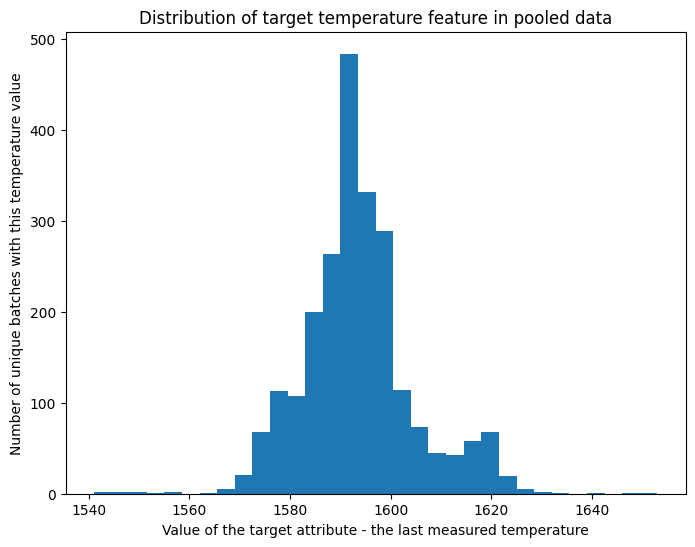

In [82]:
plt.figure(figsize=(8, 6))
plt.hist(df['temperature_y'], bins=32)
plt.xlabel('Value of the target attribute - the last measured temperature')
plt.ylabel('Number of unique batches with this temperature value')
plt.title('Distribution of target temperature feature in pooled data')
plt.show()

**The distribution of the target feature is normal, without anomalous outliers.**

### 3.8 Main conclusions of the section
* Data on the time of supply of bulk materials and wire materials were excluded from the final dataframe, because We do not use time series and the influence of this data on the target feature cannot be large.
* Data related to batch numbers from the previously generated list for deletion were excluded from the final dataframe due to anomalous values, temperature gaps, and a single temperature measurement.
* Features 4, 5, 7, 8, 9 of wire materials and 2, 7, 8, 9, 13 of bulk materials were excluded from the final dataframe due to the small number of actual objects.
* Gaps in the data on the supply of bulk and wire materials were filled with the value 0.
* Changed the type of features responsible for date and time to datatime in temperature measurement data and electrodes for subsequent data aggregation and obtaining a new feature.
* All features have been renamed in accordance with the “snake” register in English. language.
* New characteristics have been created: total active energy for each unique batch (the product of the active power allocation time and its value), as well as total active power and total reactive power for each unique batch.
* From the temperature data, a sign was obtained - the first temperature measurement for a unique batch, and as a target sign - the last temperature measurement for a unique batch.
* The data was combined into the final dataframe based on the key attribute - the batch number.
* There are no gaps in the data in the combined dataframe, all data looks correct.
* Number of objects for modeling = 2324, which is quite a bit; against the background of a small number of objects, a not very good prediction result may be obtained, we will check further.
* Feature values vary greatly from each other, to get a good result when using linear regression you will need to normalize these features in the next section.
* There is a high linear correlation (above 0.8) between the characteristics responsible for active and reactive power, as well as active energy. To eliminate multicollinearity, from these three features, only the active energy feature was left for the sample, with which we will work with linear regression (df_linreg), due to its greatest correlation with the target feature.
* As a result, we obtained a sample (df) for the boosting model with 19 features and 1 target feature. For linear regression - a sample (df_linreg) with 17 features and 1 target feature. The target attribute is temperature_y.

## 4. Machine learning

**We will use two models for modeling - linear regression and a boosting model - CatBoost.**

### 4.1 Linear regression

**As noted earlier, linear regression is particularly sensitive to non-normalized features. So the plan is this:**

* We divide the combined data for linear regression into two datasets - with features and with the target feature.
* We divide the samples into training and test in the ratio of 75% and 25%, use the value random_state = SEED.
* Apply feature normalization using MinMaxScaler.
* Using cross_validate we calculate MAE for linear regression with 5 folds.
* Determine the best MAE value on the training set for linear regression.
* Determine the training time and linear regression prediction time.

In [83]:
X_linreg = df_linreg.drop('temperature_y', axis=1)
y_linreg = df_linreg['temperature_y']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_linreg,
                                                                y_linreg,
                                                                test_size=0.25,
                                                                shuffle=True,
                                                                random_state=SEED)
scaler = MinMaxScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)
model_lr = LinearRegression()

cv_linreg = cross_validate(
                model_lr,
                X_train_lr_scaled,
                y_train_lr,
                scoring='neg_mean_absolute_error',
                cv=5)

linreg_mae_train = round(-1*max(cv_linreg['test_score']), 2)
linreg_fit_time_train = round(cv_linreg['fit_time'].mean(), 5)
linreg_score_time_train = round(cv_linreg['score_time'].mean(), 5)
print('Best MAE value for LinReg on the training set =', linreg_mae_train)
print('Average training time for LinReg on the training set =', linreg_fit_time_train)
print('Average prediction time of LinReg on the training set =', linreg_score_time_train)

Best MAE value for LinReg on the training set = 6.29
Average training time for LinReg on the training set = 0.02155
Average prediction time of LinReg on the training set = 0.0029


### 4.2 CatBoost boosting model

**The plan for the boosting model is as follows:**

* We divide the combined data into two datasets - with features and with the target feature.
* We divide the samples into training and test in the ratio of 75% and 25%, use the value random_state = SEED.
* We set the ranges of hyperparameter values that we will iterate through in GridSearchCV.
* Use GridSearchCV to find the best combination of CatBoostRegressor hyperparameters that gives the best MAE on the training set. We fix the model with the best combination of hyperparameters.
* Determine the best MAE value on the training set for linear regression.
* Determine the training time and linear regression prediction time.

In [84]:
X_cbr = df.drop('temperature_y', axis=1)
y_cbr = df['temperature_y']
X_train_cbr, X_test_cbr, y_train_cbr, y_test_cbr = train_test_split(X_cbr,
                                                                     y_cbr,
                                                                     test_size=0.25,
                                                                     shuffle=True,
                                                                     random_state=SEED)

model_cbr = CatBoostRegressor(random_state=SEED, silent=True)
param_cbr = {'learning_rate': [0.1, 0.01, 1],
              'depth': [4, 6, 8, 10],
              'n_estimators': [100, 200]}
grid_cbr = GridSearchCV(estimator=model_cbr,
                         param_grid=param_cbr,
                         cv=5,
                         scoring='neg_mean_absolute_error')
grid_cbr.fit(X_train_cbr, y_train_cbr)
best_model_cbr = grid_cbr.best_estimator_
print(f'Best CBR model hyperparameters: {grid_cbr.best_params_}')

cbr_mae_train = round(-1 * grid_cbr.best_score_, 2)
cbr_fit_time_train = round(
     pd.DataFrame(grid_cbr.cv_results_).iloc[grid_cbr.best_index_]['mean_fit_time'], 5)
cbr_score_time_train = round(
     pd.DataFrame(grid_cbr.cv_results_).iloc[grid_cbr.best_index_]['mean_score_time'], 5)
print(f'Best MAE metric value for CBR model on training set = {cbr_mae_train}')
print(f'Training time of the CBR model with the best score on the training set = {cbr_fit_time_train}')
print(f'CBR prediction time with best score on training set = {cbr_score_time_train}')
best_model_cbr = grid_cbr.best_estimator_

Best CBR model hyperparameters: {'depth': 8, 'learning_rate': 0.1, 'n_estimators': 100}
Best MAE metric value for CBR model on training set = 6.6
Training time of the CBR model with the best score on the training set = 1.46143
CBR prediction time with best score on training set = 0.00323


**On the training data, linear regression performed best with the result MAE = 6.29.**

**The MAE metric result for the CatBoostRegressor model was 6.6.**

**At the same time, the training time of linear regression is significantly better than that of the CatBoostRegressor model: 21.6 ms versus 1461 ms.**

**Accordingly, we will test linear regression on the test sample.**

### 4.3 Verification of linear regression model on test data

In [85]:
model_lr.fit(X_train_lr_scaled, y_train_lr)
pred_test_lr = model_lr.predict(X_test_lr_scaled)
print("MAE of linear regression on test set: ", round(mean_absolute_error(y_test_lr, pred_test_lr),2))

MAE of linear regression on test set:  6.66


**The obtained MAE value satisfies the primary condition of the problem: MAE < 6.8.**

**Let us now check the influence of features on the predictions of the linear regression model.**

**Positive values of the coefficients indicate a positive influence of the characteristic on the target variable, and negative values indicate a negative influence. The values of the coefficients also indicate the strength of the influence of the attribute: the larger the absolute value of the coefficient, the stronger the influence of the attribute on the model’s predictions.**

In [86]:
coefficients = list(model_lr.coef_)
features = df_linreg.drop('temperature_y', axis=1).columns.to_list()
linreg_coef = pd.DataFrame({'features':features,
                            'coeff':coefficients,
                            'coeff_abs':[abs(x) for x in coefficients]})
print('Coefficients for each attribute, reflecting the influence of the attribute on the predictions of the linear regression model:')
linreg_coef.sort_values(by='coeff_abs', ascending=False)[['features', 'coeff']].head(10)

Coefficients for each attribute, reflecting the influence of the attribute on the predictions of the linear regression model:


,features,coeff
15,active_energy,32.677372
16,temperature_x,27.398625
0,bulk1,-26.017597
14,wire6,-18.903589
12,wire2,-13.483107
7,bulk12,11.879882
11,wire1,11.496942
3,bulk5,-10.020272
4,bulk6,-9.506221
10,gas1,-8.827962


**We see that the following features have the greatest influence on the model:**
* Active energy - active_energy.
* The first measured temperature in the ladle is temperature_x.
* Volume of the first category of bulk materials - bulk1.
* The scope of the sixth and second categories of wire materials is wire6 and wire2.

**Now we check the model for adequacy using the constant model.**

### 4.4 Checking models for adequacy

**Let's check the models for adequacy using the Dummy Model from the sklearn class, having previously imported it in the first step.**

**The check is that the quality of the trained model chosen above is higher than the quality of the Dummy model, which predicts the result without relying on the features of the training set.**

In [87]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                    'constant':(1580,1620,1)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1)
gridsearch_dummy.fit(X_train_cbr, y_train_cbr)
print('The best MAE metric value for the Dummy model on the training set=',
      round((-1 * gridsearch_dummy.best_score_), 2))

The best MAE metric value for the Dummy model on the training set= 8.13


In [88]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(X_test_cbr)
print('The best MAE metric value for the Dummy model on the test set =',
      round(mean_absolute_error(y_test_cbr, predict_dummy),2))

The best MAE metric value for the Dummy model on the test set = 7.88


**As a result, using the Dummy model, it was possible to obtain the best quality of the model with an MAE equal to 7.88 on the test set, which is lower than the best result of the selected and trained linear regression model. Which proves the adequacy of the model we found and selected.**

### 4.5 Key conclusions after this section
* The combined final dataset was divided into two versions - one for linear regression, where two features (active power and reactive power) that could cause multicollinearity and disrupt the correct results of this model were excluded. The second version is complete, for the boosting model CatBoostRegressor. As a result, for linear regression the sample consisted of 17 features and 1 target feature. For the boosting model CatBoostRegressor, the sample consisted of 19 features and 1 target feature.
* The division of samples into training and testing was in the ratio of 75% and 25% according to the problem conditions using train_test_split with random_state = 220523 specified according to the problem conditions.
* For the sample with which linear regression worked, features were additionally standardized using MinMaxScaler(), because models of this type are sensitive to a large spread of values in features.
* Cross-validation was used to evaluate linear regression using cross_validate, the number of folds was taken to be 5.
* Using linear regression on the training set, the best result for the MAE metric was 6.29, while the training time was 3.4 ms.
* Using the boosting model CatBoostRegressor, the best MAE metric result of 6.6 was obtained on the training set, with a training time of 191 ms. The combination of hyperparameters with which this result was achieved: 'depth' = 8, 'learning_rate' = 0.1, 'n_estimators' = 100, random_state = 220523.
* Based on the results of testing on the training set, a linear regression model was selected for prediction on the test set.
* On the test sample, linear regression showed a MAE metric result of 6.66, which satisfies the initial condition of the task - obtaining MAE < 6.8.
* The influence of features on the linear regression prediction result was studied. The most positive influence was exerted by the signs active energy (active_energy) and the first measured temperature value in the ladle (temperature_x).
* The adequacy of the models was checked using the DummyRegressor constant model. Using this model, it was possible to obtain an MAE value of 8.13 on the training data, and 7.88 on the test data. What is worse are the results obtained using linear regression and the boosting model, which prove the adequacy of the linear regression model we have chosen.

## 5. Report

### 5.1 Comparison of solution and plan

**Original plan:**

* Do not use data on the feeding time of bulk materials and wire materials, because We do not use time series and the influence of this data on the target attribute cannot be great; we will limit ourselves only to data on the data volumes of two types of materials.
* From all further used dataframes we delete data that corresponds to batch numbers from the generated list for deletion, due to anomalous values, gaps in temperature and single temperature records.
* Due to the small number of actual objects, we exclude from further analysis signs 4, 5, 7, 8, 9 wire materials and 2, 7, 8, 9, 13 bulk materials in the next section.
* Gaps in the data on the supply of bulk and wire materials are filled in with 0.
* It is necessary to change the type of some features and rename them in accordance with the “snake” register in English. language.
* Creation of new features: active energy for each unique batch, as well as total power, both active and reactive, for each unique batch.
* Of the temperature data, only the first temperature measurement should be used as a characteristic, and the last temperature measurement for a unique batch should be used as a target characteristic.
* Data merging will occur based on the key attribute - a unique batch number.
* Evaluation of a new aggregated dataset for correlation between features and distribution of the target feature.
* Selection of two models, one of which is linear, the second is boosting.
* Dividing the data into training and test samples in a ratio of 75 to 25.
* Standardization of features for linear models.
* Use cross-validation and automated hyperparameter selection where applicable.
* Selecting the best model on the training set using the MAE metric.
* Testing the best model on a test sample.
* Assessing the adequacy of the model in terms of comparison with the MAE metric of the constant model.

**All main points of the plan were completed.**


### 5.2 Description of project difficulties

**In general, there were no particular difficulties. The main difficulty is the large amount of information, detailed analysis and research of it.

### 5.3 Key steps to solve the problem

* Data processing;
* Exploratory data analysis;
* Data preprocessing and obtaining an aggregated dataset;
* Development and selection of the best model with subsequent testing on a test sample;
* Checking the selected model for adequacy using a constant model.
* Report.

### 5.4 Features used for training and their processing
* The final aggregated dataframe consists of 19 features, 1 target feature and 2324 records.
* The training and test set are divided in the ratio of 75% to 25%.
* 15 signs are based on the volume of supplied bulk materials and wire, as well as the amount of purge gas.
* 2 characteristics are based on the total values of active and reactive power for a unique batch.
* 1 sign is based on the total active energy for a unique batch, generated based on the sum of the product of active power and the time of its release for each moment for a unique batch.
* 1 sign - the first measured temperature in the ladle for a unique batch
- 1 target feature - the last measured temperature in the ladle for a unique batch


### 5.5 Full description of the model used
* Two models were trained - linear regression and the boosting model CatBoostRegressor. The best result on the training set was shown by linear regression, MAE metric = 6.29, training time 3.4 ms.
* At the same time, the best result of the boosting model CatBoostRegressor on the training set: MAE = 6.6, training time 191 ms. The combination of hyperparameters with which this result was achieved: 'depth' = 8, 'learning_rate' = 0.1, 'n_estimators' = 100, random_state = 220523.
* For the test sample, linear regression was chosen, which showed the result of the MAE metric equal to 6.66, which satisfies the initial condition of the task - obtaining MAE < 6.8.
* The adequacy of the models was checked using the DummyRegressor constant model. Using this model, it was possible to obtain an MAE value of 8.13 on the training data, and 7.88 on the test data. What is worse are the results obtained using linear regression and the boosting model, which prove the adequacy of the linear regression model we have chosen.

### 5.6 Final metric
* On the test sample, linear regression showed an MAE result of 6.66.

### 5.7 Recommendations for improving the solution
* There was not a very large amount of data presented to obtain a high result of the boosting model; one could try to artificially increase the original sample using resampling.
* Consider a wider set of hyperparameters in the boosting model. * Create more new features.
* Leave in the sample those features that have higher values of the coefficient of influence on the prediction of the target variable for a given model.